<a href="https://colab.research.google.com/github/thspanos/AI-LAb/blob/main/Thomas_Spanos_Lambda_IDS_to_IPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#εγκατάσταση πακέτου tensorflow (hhttps://www.tensorflow.org/)
!pip install tensorflow
#εγκατάσταση πακέτου scikit-learn (https://scikit-learn.org/)
!pip install scikit-learn

In [13]:
#εισαγωγή βιβλιοθηκών - πακέτων
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [14]:
#συνάρτηση εισαγωγής συνόλου δεδομένων
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    X = df.drop('target', axis=1).values
    y = df['target'].values
    return X, y

In [15]:
#συνάρτηση δημιουργίας και εκπαίδευσης νευρωνικού δικτύου
def create_and_train_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
#συνάρτηση αξιολόγησης μοντέλου και εκτύπωσης αποτελέσματων κατηγοριοποίησης
def evaluate_model(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    accuracy = classification_report(y_test, y_pred, output_dict=True)
    return accuracy['accuracy']

In [17]:
#συνάρτηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μετά από πλήθος ροών δεδομένων (streaming lambda architecture with periodic retraining)
def simulate_streaming_lambda_architecture(csv_file_path, model, scaler, batch_size=500, retrain_every_batches=800, total_batches=8000):
    batch_counter = 0
    train_accuracies = []
    test_accuracies = []

    while batch_counter < total_batches:
        #φόρτωση συνόλου δεδομένων από csv αρχείο
        X, y = load_dataset(csv_file_path)

        #τυποποίηση (standardize) δεδομένων
        X = scaler.transform(X)

        #κατάτμηση δεδομένων σε ροές (batches)
        for i in range(0, len(X), batch_size):
            batch_counter += 1
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            #εκπαίδευση μοντέλου με κάθε ροή δεδομένων
            model.train_on_batch(X_batch, y_batch)

            #περιοδική εκπαίδευση μοντέλου με όλα τα δεδομένα
            if batch_counter % retrain_every_batches == 0:
                #τμηματοποίηση δεδομένων σε σύνολα εκπαίδευσης και δοκιμών
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                #επανεκπαίδευση μοντέλου με όλα τα δεδομένα
                model = create_and_train_model(X_train.shape[1])
                model.fit(X_train, y_train, epochs=5, batch_size=64)  # Train for a few epochs

                #αποθήκευση των βαρών (weights) του μοντέλου για μελλοντική επανεκπαίδευση
                model.save('model_weights.keras')

                #αξιολόγηση του μοντέλου στα σύνολα εκπαίδευσης και δοκιμών
                train_accuracy = evaluate_model(model, X_train, y_train)
                test_accuracy = evaluate_model(model, X_test, y_test)

# --- IPS block
                y_pred = np.argmax(model.predict(X_test), axis=1)   # (N,)
                blocked_indices = np.where(y_pred == 2)[0]
                if blocked_indices.size > 0:
                    print(f"Blocking {len(blocked_indices)} malicious traffic instances.")
# --- IPS block ---


                train_accuracies.append(train_accuracy)
                test_accuracies.append(test_accuracy)

                print(f"Batch {batch_counter}, Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    #εκτύπωση γραφικής απεικόνισης ακρίβειας μοντέλου
    plt.plot(range(1, total_batches+1, retrain_every_batches), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, total_batches+1, retrain_every_batches), test_accuracies, label='Test Accuracy')
    plt.xlabel('Batch Number')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy Over Batches')
    plt.legend()
    plt.show()

In [18]:
#θέση αρχείου csv με το σύνολο δεδομένων
csv_file_path = 'https://raw.githubusercontent.com/thspanos/AI-LAb/refs/heads/main/Data/pcap_data.csv'

In [19]:
#τυποποίηση (standardize) δεδομένων
scaler = StandardScaler()

In [20]:
#φόρτωση συνόλου δεδομένων
X, y = load_dataset(csv_file_path)
X = scaler.fit_transform(X)

In [21]:
#εκπαίδευση μοντέλου
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model = create_and_train_model(X_train.shape[1])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6283 - loss: 0.8091
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8501 - loss: 0.4867
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8701 - loss: 0.4506
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8882 - loss: 0.4165
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8897 - loss: 0.4183
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 1023 malicious traffic instances.
Batch 800, Training Accuracy: 0.9126, Test Accuracy: 0.9028
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6361 - loss: 0.8125
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8481 - loss: 0.4971
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8687 - loss: 0.4562
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8826 - loss: 0.4244
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8933 - loss: 0.4020
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 1007 malicious traffic instances.
Batch 1600, Training Accuracy: 0.9143, Test Accuracy: 0.9038
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6428 - loss: 0.8069
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8465 - loss: 0.5001
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8667 - loss: 0.4518
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8843 - loss: 0.4174
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8919 - loss: 0.3990
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 998 malicious traffic instances.
Batch 2400, Training Accuracy: 0.9143, Test Accuracy: 0.9035
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6308 - loss: 0.8218
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8482 - loss: 0.4798
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8740 - loss: 0.4501
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8841 - loss: 0.4203
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8923 - loss: 0.4002
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 1007 malicious traffic instances.
Batch 3200, Training Accuracy: 0.9154, Test Accuracy: 0.9051
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6475 - loss: 0.7952
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8458 - loss: 0.4879
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8757 - loss: 0.4419
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8850 - loss: 0.4154
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8886 - loss: 0.4121
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 989 malicious traffic instances.
Batch 4000, Training Accuracy: 0.9132, Test Accuracy: 0.9038
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6261 - loss: 0.8230
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8532 - loss: 0.4857
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8739 - loss: 0.4472
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8861 - loss: 0.4120
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8879 - loss: 0.4137
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Blocking 1001 malicious traffic instances.
Batch 4800, Training Accuracy: 0.9159, Test Accuracy: 0.9058
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6313 - loss: 0.8194
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8492 - loss: 0.4977
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8768 - loss: 0.4367
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8858 - loss: 0.4249
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8941 - loss: 0.3971
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 1005 malicious traffic instances.
Batch 5600, Training Accuracy: 0.9149, Test Accuracy: 0.9045
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6325 - loss: 0.8091
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8460 - loss: 0.5121
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8698 - loss: 0.4492
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8880 - loss: 0.4120
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8911 - loss: 0.4129
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 1008 malicious traffic instances.
Batch 6400, Training Accuracy: 0.9144, Test Accuracy: 0.9038
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6499 - loss: 0.7935
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8561 - loss: 0.4832
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8733 - loss: 0.4427
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8908 - loss: 0.4173
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8979 - loss: 0.3996
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 999 malicious traffic instances.
Batch 7200, Training Accuracy: 0.9169, Test Accuracy: 0.9031
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6423 - loss: 0.7948
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8430 - loss: 0.4982
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8681 - loss: 0.4644
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8833 - loss: 0.4247
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8877 - loss: 0.4152
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 1014 malicious traffic instances.
Batch 8000, Training Accuracy: 0.9147, Test Accuracy: 0.9021


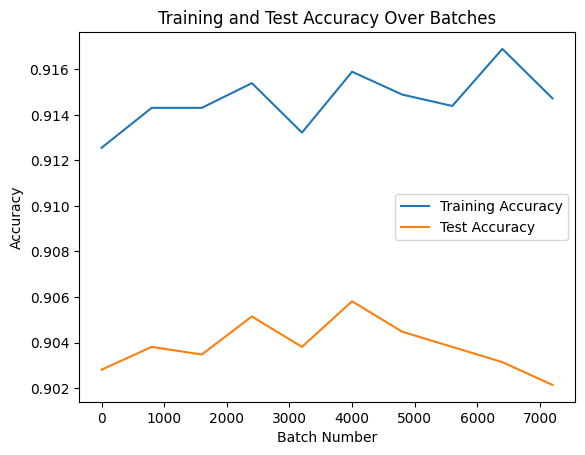

In [22]:
#εκκίνηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μοντέλου
simulate_streaming_lambda_architecture(csv_file_path, model, scaler)